 # Import necessary libraries 

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime 
from datetime import timezone
import time
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as data_utils 
import cryptocompare
from IPython.display import Image

# Define and intialize the neural network

In [197]:
class NeuralNet(nn.Module):
    """cla classe ou est défini notre model """
    def __init__(self, 
                 activation_function = nn.ReLU,
                 optimizer = Adam,
                 dropout = 0.2
                ):
        super(NeuralNet, self).__init__()
        input_dim = 14
        hidden_dim = 100
        output_dim = 1
        self.lstm1 = nn.LSTM(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p = dropout)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.layers =[nn.Dropout(p = dropout)]
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*self.layers)
        


    def forward(self, x):
        out, _ = self.lstm1(x.view(len(x), 1 , -1))
        out = self.dropout1(out.view(len(x), -1))
        out, _ = self.lstm2(out.view(len(x), 1 , -1))
        out = self.layers(out.view(len(x), -1))
        
        return out

# DATA

In [198]:

def get_data(start_date,end_date,crypto):
    """Fonction pour récuperer la data de l'api crypto compare"""
    l=[]
    i=0

    while start_date>=end_date:
        i=i+1
        print("requette :",i)
        try : 
            data = cryptocompare.get_historical_price_day(crypto, 'USD', limit=2000, exchange='CCCAGG', toTs=start_date)
            if data is None : 
                raise ValueError 
        except: 
            break

        l=data+l
        start_date=datetime.fromtimestamp(data[0]['time'])
    df = pd.DataFrame.from_dict(l)
    df=df.iloc[:,:7]
    return df

In [199]:

def read_csv(PATH):
    """fonction pour lire le csv de 'hitorique des metriques'"""
    df=pd.read_csv(PATH)
    df=df.fillna(df.mean())
    df=df.iloc[:,2:]
    return df

In [200]:
def read_csv_tweet(PATH):
    """Fonction pour lire l'historique des tweets"""
    df_tweet=pd.read_csv(PATH)
    df_tweet=df_tweet.groupby("time",as_index=False)["sentiment_analysis"].mean()
    df_tweet['time'] = pd.to_datetime(df_tweet['time'], format="%Y-%m-%d")
    df_tweet['time'] = df_tweet['time'].apply(lambda x: int(x.replace(tzinfo=timezone.utc).timestamp()))
    return df_tweet

In [201]:
def merge_data(df,df1,df2):
    """fonction pour faire la jointure entre nos dataframes 
    metriques , tweets, prix des cryptos"""
    
    df_merge=pd.merge(df,df1,on="time")
    df_merge_2=pd.merge(df_merge,df2,on='time')
    df_merge=df_merge_2
    df_merge["time"]=pd.to_datetime(df_merge["time"], unit='s')
    df_merge = df_merge.set_index('time')
    df_merge.index = pd.to_datetime(df_merge.index, unit='s')
    return df_merge

In [202]:
def split_data(data, train_prop=80):
    """fonction pour spliter notre data set 
    en data test et train"""
    
    train_data = data.iloc[:int(train_prop * len(data))]
    test_data = data.iloc[int(train_prop * len(data)):]
    return train_data, test_data

In [203]:
def normalize_data(traindf,min_max_scaler=None):
    """ fonction pour normaliser nos données """
    x = traindf.values
    if min_max_scaler is None:
        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit(x)
    x_scaled=min_max_scaler.transform(traindf.values)
    normalized_df = pd.DataFrame(x_scaled, columns = traindf.columns)
    return normalized_df,min_max_scaler

In [204]:
def denormalize_data(min_max_scaler, normalized_df):
    """fonction inverse de notre normalisation"""
    new_x = normalized_df.values* (min_max_scaler.data_max_-min_max_scaler.data_min_) + min_max_scaler.data_min_
    return pd.DataFrame(new_x, columns = df.columns)

In [205]:
def plot_curves(to_plot,labels, title='', x_label='', y_label=''):
    """fonction pour afficher le graphe de prix de la cryptos  par la  Date"""
    fig, ax = plt.subplots(1, figsize=(14, 7))
    for i in range(len(to_plot)):
        ax.plot(to_plot[i], label=labels[i])
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
############plot_curves([train_data['close'], test_data['close']], ['training', 'test'], title='btc')

In [206]:
def create_data_loader(train_normalized):
    """fonction qui creer notre tensor pour le train """
    train_target_tensor = torch.tensor(train_normalized['close'].values.astype(np.float64))
    train_data_tensor = torch.tensor(train_normalized.drop('close', axis = 1).values) 
    train_tensor = data_utils.TensorDataset(train_data_tensor, train_target_tensor) 
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32, shuffle = True)
    return train_loader


def create_data_loader_test(test_data,scaler):
    """fonction qui creer notre tensor pour le test """
    test_normalized,_ = normalize_data(test_data,scaler)
    test_target = torch.tensor(test_normalized['close'].values.astype(np.float64))
    test = torch.tensor(test_normalized.drop('close', axis = 1).values) 
    print(test_target[0])
    test_tensor = data_utils.TensorDataset(test, test_target) 
    test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 32, shuffle = False)
    return test_loader



In [207]:
def pourcentage_error(predected_price,real_price):
    """"fonction qui calcule le pourcentage d'erreur"""
    s=0
    for i in range (len(predected_price)):
        s=s+(abs(predected_price[i]-real_price[i])/real_price[i])
    return s/(len(predected_price))

In [208]:
from tqdm import tqdm

def model(train_loader,epochs=1000):
    """fonction qui initialise notre entrainement """
    model = NeuralNet()

    EPOCHS = epochs

    #target = pd.DataFrame(data = train_normalized['close'])


    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    losses = []
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for bidx, batch in tqdm(enumerate(train_loader)):
            X, Y = batch
            model.zero_grad()
            loss = 0
            for i in range(len(X)):
                x, y = X[i], Y[i]
                x = x.view(-1, len(x))

                #Forward Pass
                y_hat = model(x.float())

                #Loss
                loss += criterion(y.float(), y_hat.float())

            #Backward pass
            loss.backward()

            #Parameters optimization
            optimizer.step()

            epoch_loss += float(loss)

        losses.append(epoch_loss)
        model_close=model
        print("Epoch ", epoch, ": ", epoch_loss)
    return model

In [195]:
def predict(model,test_loader,scaler):
    """fonction utiliser pour la prédiction"""
    y_list = []
    y_hat_list = []
    min_max_scaler=scaler
    for bidx, batch in tqdm(enumerate(test_loader)):
            X, Y = batch
            for i in range(len(X)):
                x, y = X[i], Y[i]
                x = x.view(-1, len(x))
                y_hat = model(x.float())
                
                print(y_hat)
                vmin = min_max_scaler.data_min_[5]
                vmax = min_max_scaler.data_max_[5]
                y_hat_list.append(float(y_hat)* (vmax - vmin) + vmin)
    return y_hat_list

In [209]:
#Nos inputs
START_DATE=datetime.now()
END_DATE=datetime(2010,6,18)
CRYPTO='ETH'
#PATHz='/home/jbouhadoun/esgi/PA5_Crypto-Advice/src/scrapper/outputs/ltc_2018-01-01_2021-06-25.csv'
PATH_BTC="/home/jbouhadoun/Téléchargements/histo_eth (1).csv"
PATH_BTC_TWEET="/home/jbouhadoun/esgi/exp/final_data/historical_eth_twitter_withsentiment.csv"
PATH_MODEL_BTC=""
PATH_scaler_BTC=""

In [213]:
#dataframe d
df=get_data(START_DATE,END_DATE,CRYPTO)
df1=read_csv(PATH_BTC)
df2=read_csv_tweet(PATH_BTC_TWEET)



df_merge=merge_data(df,df1,df2)
#print(df_merge.columns)
#df_merge=df_merge.drop(columns=["coin"])
train_data,test_data=split_data(df_merge,0.9)
train_normalized,scaler = normalize_data(train_data)
train_loader=create_data_loader(train_normalized)
test_loader=create_data_loader_test(test_data,scaler)


#df_merge.to_csv("/home/jbouhadoun/esgi/exp/juscrap/outputs/train_btc.csv")
df_merge.head()

requette : 1
requette : 2
requette : 3
tensor(0.9871, dtype=torch.float64)


,high,low,open,volumefrom,volumeto,close,addresses_active_count,addresses_new_non_zero_count,addresses_count,addresses_receiving_count,addresses_sending_count,transactions_transfers_volume_sum,mining_hash_rate_mean,mining_difficulty_latest,sentiment_analysis
time,,,,,,,,,,,,,,,
2017-01-01,8.891,7.970,8.018,854000.05,6963216.69,8.154,13695,1357,729071,12933,6215,1.818131e+06,5.646216e+12,8.174688e+13,0.120282
2017-01-02,8.568,7.964,8.154,859902.07,7152179.49,8.317,14916,1901,730972,13899,7320,2.857197e+06,5.646488e+12,8.278692e+13,0.054745
2017-01-03,9.940,8.185,8.335,571218.00,5292231.64,9.595,14612,2518,733490,13201,8236,5.066915e+06,5.623616e+12,8.197531e+13,0.127372
2017-01-04,11.500,10.240,9.639,2063444.32,22695239.44,11.000,17688,3245,736735,15979,10535,7.864367e+06,6.200869e+12,8.832221e+13,0.063388
2017-01-05,10.370,9.151,11.000,2134380.99,21602177.79,10.120,18556,3123,739858,16927,9962,8.078451e+06,6.344418e+12,9.108022e+13,0.096465


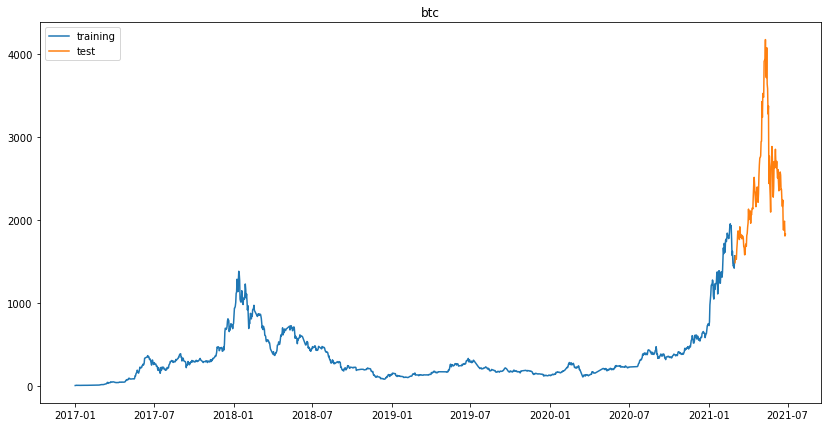

In [138]:
plot_curves([train_data['close'], test_data['close']], ['training', 'test'], title='btc')

In [1]:
df_merge

NameError: name 'df_merge' is not defined

In [140]:
#Entrainement DU model
model_btc=model(train_loader,500)

0it [00:00, ?it/s]/home/jbouhadoun/anaconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
42it [00:01, 32.36it/s]
4it [00:00, 39.39it/s]

Epoch  0 :  55.88609865307808


42it [00:01, 33.51it/s]
4it [00:00, 34.71it/s]

Epoch  1 :  44.7178785353899


42it [00:01, 37.27it/s]
4it [00:00, 38.44it/s]

Epoch  2 :  36.619838565588


42it [00:00, 42.53it/s]
5it [00:00, 42.75it/s]

Epoch  3 :  30.95650824904442


42it [00:00, 43.00it/s]
5it [00:00, 42.20it/s]

Epoch  4 :  27.295804038643837


42it [00:01, 41.92it/s]
4it [00:00, 39.36it/s]

Epoch  5 :  23.863416850566864


42it [00:00, 42.61it/s]
4it [00:00, 36.56it/s]

Epoch  6 :  19.975028082728386


42it [00:01, 40.87it/s]
4it [00:00, 36.83it/s]

Epoch  7 :  16.741982743144035


42it [00:01, 41.76it/s]
4it [00:00, 35.78it/s]

Epoch  8 :  12.11042856425047


42it [00:00, 42.28it/s]
5it [00:00, 42.06it/s]

Epoch  9 :  8.872009828686714


42it [00:00, 43.34it/s]
5it [00:00, 42.72it/s]

Epoch  10 :  6.704477097839117


42it [00:00, 43.50it/s]
4it [00:00, 37.63it/s]

Epoch  11 :  4.603839857503772


42it [00:01, 41.43it/s]
5it [00:00, 42.17it/s]

Epoch  12 :  3.5119284614920616


42it [00:00, 42.94it/s]
4it [00:00, 35.06it/s]

Epoch  13 :  2.8970023840665817


42it [00:01, 41.96it/s]
5it [00:00, 42.86it/s]

Epoch  14 :  2.514661295339465


42it [00:00, 43.72it/s]
5it [00:00, 43.34it/s]

Epoch  15 :  2.542091293260455


42it [00:00, 43.24it/s]
5it [00:00, 42.35it/s]

Epoch  16 :  2.0937602277845144


42it [00:00, 43.59it/s]
5it [00:00, 43.39it/s]

Epoch  17 :  2.003259601071477


42it [00:00, 43.78it/s]
5it [00:00, 43.42it/s]

Epoch  18 :  2.0038127806037664


42it [00:00, 43.79it/s]
5it [00:00, 43.32it/s]

Epoch  19 :  1.953280983492732


42it [00:00, 43.40it/s]
5it [00:00, 41.86it/s]

Epoch  20 :  1.95004827901721


42it [00:00, 43.24it/s]
5it [00:00, 42.52it/s]

Epoch  21 :  1.6030670199543238


42it [00:00, 42.43it/s]
5it [00:00, 42.32it/s]

Epoch  22 :  1.9624422751367092


42it [00:00, 43.56it/s]
5it [00:00, 43.93it/s]

Epoch  23 :  1.7550257574766874


42it [00:00, 43.44it/s]
5it [00:00, 43.73it/s]

Epoch  24 :  1.5606283098459244


42it [00:00, 43.57it/s]
5it [00:00, 43.65it/s]

Epoch  25 :  1.476726384833455


42it [00:00, 43.53it/s]
5it [00:00, 43.52it/s]

Epoch  26 :  1.5850130124017596


42it [00:00, 43.44it/s]
5it [00:00, 43.30it/s]

Epoch  27 :  1.4278069911524653


42it [00:00, 43.77it/s]
5it [00:00, 41.16it/s]

Epoch  28 :  1.4091881448403


42it [00:00, 42.83it/s]
4it [00:00, 33.02it/s]

Epoch  29 :  1.3488715831190348


42it [00:01, 39.32it/s]
5it [00:00, 40.80it/s]

Epoch  30 :  1.5402878490276635


42it [00:01, 40.97it/s]
4it [00:00, 39.17it/s]

Epoch  31 :  1.4501406932249665


42it [00:01, 40.06it/s]
5it [00:00, 40.50it/s]

Epoch  32 :  1.3387029515579343


42it [00:01, 40.53it/s]
4it [00:00, 39.64it/s]

Epoch  33 :  1.4095885045826435


42it [00:01, 41.78it/s]
5it [00:00, 43.10it/s]

Epoch  34 :  1.3157192030921578


42it [00:01, 41.86it/s]
4it [00:00, 39.63it/s]

Epoch  35 :  1.4466370800510049


42it [00:01, 40.60it/s]
4it [00:00, 38.91it/s]

Epoch  36 :  1.1207901882007718


42it [00:01, 39.70it/s]
4it [00:00, 39.97it/s]

Epoch  37 :  1.2200515493750572


42it [00:01, 39.90it/s]
4it [00:00, 37.62it/s]

Epoch  38 :  1.3474986776709557


42it [00:01, 39.93it/s]
4it [00:00, 39.19it/s]

Epoch  39 :  1.1093518384732306


42it [00:01, 40.96it/s]
4it [00:00, 39.52it/s]

Epoch  40 :  1.2919494369998574


42it [00:00, 42.29it/s]
4it [00:00, 34.91it/s]

Epoch  41 :  1.3431517854332924


42it [00:01, 40.28it/s]
4it [00:00, 36.85it/s]

Epoch  42 :  1.0593924671411514


42it [00:01, 41.35it/s]
5it [00:00, 42.44it/s]

Epoch  43 :  1.1168773584067822


42it [00:01, 41.45it/s]
4it [00:00, 39.13it/s]

Epoch  44 :  1.1545786941424012


42it [00:00, 42.43it/s]
5it [00:00, 43.11it/s]

Epoch  45 :  1.0756850857287645


42it [00:01, 40.35it/s]
4it [00:00, 38.80it/s]

Epoch  46 :  1.072226857766509


42it [00:01, 39.12it/s]
4it [00:00, 39.23it/s]

Epoch  47 :  1.11429557017982


42it [00:01, 41.22it/s]
5it [00:00, 41.63it/s]

Epoch  48 :  1.0271339993923903


42it [00:01, 40.65it/s]
8it [00:00, 39.88it/s]

Epoch  49 :  1.1018964070826769


42it [00:01, 41.98it/s]
5it [00:00, 42.07it/s]

Epoch  50 :  1.1427149511873722


42it [00:01, 39.27it/s]
4it [00:00, 34.73it/s]

Epoch  51 :  1.1078779743984342


42it [00:01, 41.17it/s]
5it [00:00, 41.42it/s]

Epoch  52 :  1.0933271488174796


42it [00:01, 39.40it/s]
4it [00:00, 38.67it/s]

Epoch  53 :  0.9614111036062241


42it [00:01, 40.41it/s]
5it [00:00, 42.50it/s]

Epoch  54 :  0.9827394979074597


42it [00:00, 43.01it/s]
5it [00:00, 42.53it/s]

Epoch  55 :  0.8633527550846338


42it [00:00, 43.26it/s]
5it [00:00, 43.00it/s]

Epoch  56 :  0.9103375095874071


42it [00:01, 40.54it/s]
5it [00:00, 41.24it/s]

Epoch  57 :  0.995463827624917


42it [00:01, 41.74it/s]
5it [00:00, 41.16it/s]

Epoch  58 :  0.9400144843384624


42it [00:01, 41.64it/s]
4it [00:00, 34.35it/s]

Epoch  59 :  0.9832228519953787


42it [00:01, 40.78it/s]
5it [00:00, 41.26it/s]

Epoch  60 :  0.8868562653660774


42it [00:01, 41.16it/s]
5it [00:00, 41.20it/s]

Epoch  61 :  0.9293682333081961


42it [00:01, 38.23it/s]
4it [00:00, 39.75it/s]

Epoch  62 :  0.907146630808711


42it [00:01, 41.74it/s]
5it [00:00, 40.47it/s]

Epoch  63 :  0.9393111295066774


42it [00:01, 41.13it/s]
5it [00:00, 41.73it/s]

Epoch  64 :  0.9731687339954078


42it [00:01, 40.62it/s]
4it [00:00, 35.22it/s]

Epoch  65 :  0.8248755591921508


42it [00:01, 40.76it/s]
4it [00:00, 32.93it/s]

Epoch  66 :  0.9100934443995357


42it [00:01, 39.09it/s]
4it [00:00, 39.68it/s]

Epoch  67 :  0.8118168688379228


42it [00:01, 39.75it/s]
4it [00:00, 39.87it/s]

Epoch  68 :  0.9404263757169247


42it [00:01, 39.44it/s]
4it [00:00, 39.31it/s]

Epoch  69 :  0.7904653125442564


42it [00:01, 39.65it/s]
4it [00:00, 39.53it/s]

Epoch  70 :  0.8161874306388199


42it [00:01, 40.06it/s]
5it [00:00, 41.74it/s]

Epoch  71 :  0.7883638376370072


42it [00:00, 43.01it/s]
5it [00:00, 42.72it/s]

Epoch  72 :  0.9657486113719642


42it [00:01, 41.87it/s]
5it [00:00, 42.28it/s]

Epoch  73 :  0.8471525320783257


42it [00:00, 43.08it/s]
5it [00:00, 42.95it/s]

Epoch  74 :  0.8479609312489629


42it [00:00, 43.20it/s]
5it [00:00, 43.16it/s]

Epoch  75 :  0.7567363674752414


42it [00:00, 43.00it/s]
5it [00:00, 42.66it/s]

Epoch  76 :  0.8920704005286098


42it [00:01, 41.29it/s]
4it [00:00, 36.18it/s]

Epoch  77 :  0.7989081875421107


42it [00:01, 40.13it/s]
5it [00:00, 42.06it/s]

Epoch  78 :  0.8487789337523282


42it [00:01, 41.28it/s]
5it [00:00, 42.90it/s]

Epoch  79 :  0.7307331594638526


42it [00:00, 42.44it/s]
5it [00:00, 42.50it/s]

Epoch  80 :  0.7158227399922907


42it [00:01, 41.67it/s]
4it [00:00, 38.45it/s]

Epoch  81 :  0.908860030118376


42it [00:01, 40.73it/s]
5it [00:00, 41.01it/s]

Epoch  82 :  0.7961733876727521


42it [00:01, 41.44it/s]
5it [00:00, 41.60it/s]

Epoch  83 :  0.7577468417584896


42it [00:01, 41.30it/s]
4it [00:00, 39.51it/s]

Epoch  84 :  0.7535980525426567


42it [00:01, 41.17it/s]
5it [00:00, 41.08it/s]

Epoch  85 :  0.7643105168826878


42it [00:01, 40.50it/s]
5it [00:00, 41.55it/s]

Epoch  86 :  0.6086850087158382


42it [00:01, 41.30it/s]
5it [00:00, 41.10it/s]

Epoch  87 :  0.7510976532939821


42it [00:01, 41.39it/s]
4it [00:00, 38.73it/s]

Epoch  88 :  0.7332241898402572


42it [00:01, 40.85it/s]
5it [00:00, 40.51it/s]

Epoch  89 :  0.6635853799525648


42it [00:01, 41.38it/s]
5it [00:00, 40.83it/s]

Epoch  90 :  0.8020281428471208


42it [00:01, 41.22it/s]
4it [00:00, 39.44it/s]

Epoch  91 :  0.6948452750220895


42it [00:01, 41.08it/s]
4it [00:00, 38.77it/s]

Epoch  92 :  0.6754214242100716


42it [00:00, 42.32it/s]
5it [00:00, 41.53it/s]

Epoch  93 :  0.6079415511339903


42it [00:00, 42.64it/s]
4it [00:00, 37.79it/s]

Epoch  94 :  0.6381394993513823


42it [00:00, 42.23it/s]
4it [00:00, 39.60it/s]

Epoch  95 :  0.6466371032875031


42it [00:01, 38.94it/s]
4it [00:00, 37.74it/s]

Epoch  96 :  0.7608210584148765


42it [00:01, 34.45it/s]
4it [00:00, 39.42it/s]

Epoch  97 :  0.6773190759122372


42it [00:01, 41.32it/s]
4it [00:00, 34.96it/s]

Epoch  98 :  0.5841328483074903


42it [00:01, 38.33it/s]
4it [00:00, 38.98it/s]

Epoch  99 :  0.6079353457316756


42it [00:01, 39.03it/s]
5it [00:00, 42.37it/s]

Epoch  100 :  0.5690587640274316


42it [00:01, 41.81it/s]
5it [00:00, 42.17it/s]

Epoch  101 :  0.7309436097275466


42it [00:00, 42.11it/s]
5it [00:00, 42.17it/s]

Epoch  102 :  0.5068829928059131


42it [00:00, 42.29it/s]
5it [00:00, 41.78it/s]

Epoch  103 :  0.7238034354522824


42it [00:00, 42.00it/s]
5it [00:00, 41.04it/s]

Epoch  104 :  0.6378224247600883


42it [00:01, 41.78it/s]
4it [00:00, 37.65it/s]

Epoch  105 :  0.6332738178316504


42it [00:01, 37.69it/s]
5it [00:00, 41.89it/s]

Epoch  106 :  0.540040161460638


42it [00:00, 43.01it/s]
5it [00:00, 43.08it/s]

Epoch  107 :  0.6111020483076572


42it [00:00, 43.10it/s]
5it [00:00, 43.16it/s]

Epoch  108 :  0.500549266114831


42it [00:01, 39.62it/s]
4it [00:00, 37.91it/s]

Epoch  109 :  0.5583362323231995


42it [00:01, 39.90it/s]
5it [00:00, 41.35it/s]

Epoch  110 :  0.5455470122396946


42it [00:01, 41.54it/s]
5it [00:00, 41.39it/s]

Epoch  111 :  0.5797173641622066


42it [00:01, 41.63it/s]
4it [00:00, 39.34it/s]

Epoch  112 :  0.4794791585300118


42it [00:01, 41.99it/s]
5it [00:00, 41.56it/s]

Epoch  113 :  0.7088212301023304


42it [00:01, 41.90it/s]
5it [00:00, 42.00it/s]

Epoch  114 :  0.5353252715431154


42it [00:00, 42.28it/s]
5it [00:00, 42.19it/s]

Epoch  115 :  0.53024827176705


42it [00:01, 41.24it/s]
5it [00:00, 40.76it/s]

Epoch  116 :  0.5311391311697662


42it [00:01, 41.08it/s]
5it [00:00, 40.62it/s]

Epoch  117 :  0.5460217958316207


42it [00:01, 41.69it/s]
5it [00:00, 41.61it/s]

Epoch  118 :  0.5778505078051239


42it [00:01, 40.92it/s]
4it [00:00, 38.66it/s]

Epoch  119 :  0.4984408961609006


42it [00:01, 41.44it/s]
5it [00:00, 41.95it/s]

Epoch  120 :  0.5636646386701614


42it [00:00, 42.09it/s]
5it [00:00, 40.99it/s]

Epoch  121 :  0.4718024586327374


42it [00:01, 41.44it/s]
5it [00:00, 41.12it/s]

Epoch  122 :  0.5672969459556043


42it [00:01, 39.32it/s]
4it [00:00, 39.08it/s]

Epoch  123 :  0.4200179517501965


42it [00:01, 39.21it/s]
4it [00:00, 37.97it/s]

Epoch  124 :  0.510371656389907


42it [00:01, 39.00it/s]
4it [00:00, 39.21it/s]

Epoch  125 :  0.5256253501866013


42it [00:01, 39.31it/s]
4it [00:00, 39.09it/s]

Epoch  126 :  0.4459758182056248


42it [00:01, 39.25it/s]
4it [00:00, 39.00it/s]

Epoch  127 :  0.5063441677484661


42it [00:01, 40.89it/s]
4it [00:00, 38.84it/s]

Epoch  128 :  0.4289296694332734


42it [00:01, 41.99it/s]
4it [00:00, 39.88it/s]

Epoch  129 :  0.5449616457335651


42it [00:00, 42.15it/s]
4it [00:00, 33.85it/s]

Epoch  130 :  0.4873136463575065


42it [00:01, 41.40it/s]
4it [00:00, 34.66it/s]

Epoch  131 :  0.47507174336351454


42it [00:01, 40.41it/s]
3it [00:00, 29.90it/s]

Epoch  132 :  0.4816525806672871


42it [00:01, 40.21it/s]
4it [00:00, 39.92it/s]

Epoch  133 :  0.5445091987494379


42it [00:01, 41.50it/s]
4it [00:00, 39.58it/s]

Epoch  134 :  0.5270432527177036


42it [00:01, 39.10it/s]
4it [00:00, 39.10it/s]

Epoch  135 :  0.5308261313475668


42it [00:01, 39.42it/s]
4it [00:00, 38.83it/s]

Epoch  136 :  0.48523764591664076


42it [00:01, 38.94it/s]
4it [00:00, 37.54it/s]

Epoch  137 :  0.4468107793945819


42it [00:01, 40.00it/s]
5it [00:00, 41.40it/s]

Epoch  138 :  0.4503000006079674


42it [00:01, 40.93it/s]
5it [00:00, 40.99it/s]

Epoch  139 :  0.4628262117039412


42it [00:01, 39.66it/s]
4it [00:00, 38.87it/s]

Epoch  140 :  0.4886815713252872


42it [00:01, 40.60it/s]
5it [00:00, 40.69it/s]

Epoch  141 :  0.4343140125274658


42it [00:01, 40.64it/s]
4it [00:00, 36.01it/s]

Epoch  142 :  0.4421073740813881


42it [00:01, 41.30it/s]
5it [00:00, 41.80it/s]

Epoch  143 :  0.5683875081595033


42it [00:01, 41.16it/s]
4it [00:00, 32.47it/s]

Epoch  144 :  0.3861445130314678


42it [00:01, 37.85it/s]
4it [00:00, 38.50it/s]

Epoch  145 :  0.49185107462108135


42it [00:01, 38.67it/s]
4it [00:00, 38.42it/s]

Epoch  146 :  0.5400952014606446


42it [00:01, 38.68it/s]
4it [00:00, 38.81it/s]

Epoch  147 :  0.47980808140709996


42it [00:01, 39.03it/s]
4it [00:00, 39.10it/s]

Epoch  148 :  0.5129077951423824


42it [00:01, 38.58it/s]
4it [00:00, 37.61it/s]

Epoch  149 :  0.4666510559618473


42it [00:01, 38.94it/s]
4it [00:00, 37.62it/s]

Epoch  150 :  0.4044528256636113


42it [00:01, 38.42it/s]
4it [00:00, 38.27it/s]

Epoch  151 :  0.52091308333911


42it [00:01, 38.75it/s]
4it [00:00, 36.42it/s]

Epoch  152 :  0.5015208509285003


42it [00:01, 37.89it/s]
4it [00:00, 37.74it/s]

Epoch  153 :  0.39751969766803086


42it [00:01, 38.94it/s]
4it [00:00, 38.44it/s]

Epoch  154 :  0.4387285124976188


42it [00:01, 39.23it/s]
4it [00:00, 38.93it/s]

Epoch  155 :  0.45149502088315785


42it [00:01, 39.20it/s]
4it [00:00, 39.34it/s]

Epoch  156 :  0.4611929659731686


42it [00:01, 41.16it/s]
5it [00:00, 41.41it/s]

Epoch  157 :  0.43723924783989787


42it [00:01, 41.42it/s]
5it [00:00, 37.97it/s]

Epoch  158 :  0.560476710088551


42it [00:01, 41.83it/s]
4it [00:00, 32.25it/s]

Epoch  159 :  0.40829465351998806


42it [00:01, 37.55it/s]
4it [00:00, 38.60it/s]

Epoch  160 :  0.4649627205217257


42it [00:01, 37.93it/s]
3it [00:00, 29.21it/s]

Epoch  161 :  0.4887554523302242


42it [00:01, 36.12it/s]
5it [00:00, 41.19it/s]

Epoch  162 :  0.3765483577735722


42it [00:01, 41.19it/s]
5it [00:00, 40.58it/s]

Epoch  163 :  0.4513160774949938


42it [00:01, 40.84it/s]
5it [00:00, 41.44it/s]

Epoch  164 :  0.48364919098094106


42it [00:00, 42.15it/s]
5it [00:00, 41.09it/s]

Epoch  165 :  0.4184701091144234


42it [00:00, 42.36it/s]
5it [00:00, 42.40it/s]

Epoch  166 :  0.44128572125919163


42it [00:00, 42.61it/s]
5it [00:00, 40.93it/s]

Epoch  167 :  0.5099258162081242


42it [00:00, 42.62it/s]
5it [00:00, 42.11it/s]

Epoch  168 :  0.408640087232925


42it [00:01, 40.88it/s]
5it [00:00, 40.77it/s]

Epoch  169 :  0.4214641307480633


42it [00:01, 39.34it/s]
4it [00:00, 38.50it/s]

Epoch  170 :  0.43359811732079834


42it [00:01, 39.24it/s]
4it [00:00, 38.83it/s]

Epoch  171 :  0.40178844844922423


42it [00:01, 38.41it/s]
5it [00:00, 42.65it/s]

Epoch  172 :  0.4527370317373425


42it [00:00, 42.09it/s]
4it [00:00, 36.13it/s]

Epoch  173 :  0.46593600418418646


42it [00:01, 41.42it/s]
5it [00:00, 40.82it/s]

Epoch  174 :  0.4789596743648872


42it [00:01, 41.95it/s]
4it [00:00, 38.90it/s]

Epoch  175 :  0.3897717581130564


42it [00:01, 41.52it/s]
5it [00:00, 40.58it/s]

Epoch  176 :  0.3397833264898509


42it [00:01, 40.86it/s]
5it [00:00, 41.06it/s]

Epoch  177 :  0.41519295307807624


42it [00:01, 41.59it/s]
5it [00:00, 41.27it/s]

Epoch  178 :  0.4035196222830564


42it [00:01, 41.78it/s]
5it [00:00, 41.46it/s]

Epoch  179 :  0.436681573279202


42it [00:01, 41.90it/s]
4it [00:00, 39.95it/s]

Epoch  180 :  0.41716837603598833


42it [00:01, 41.20it/s]
5it [00:00, 40.99it/s]

Epoch  181 :  0.40166022232733667


42it [00:01, 41.51it/s]
5it [00:00, 40.94it/s]

Epoch  182 :  0.39709209254942834


42it [00:01, 41.70it/s]
5it [00:00, 40.87it/s]

Epoch  183 :  0.4630474429577589


42it [00:01, 41.74it/s]
5it [00:00, 41.22it/s]

Epoch  184 :  0.435102405725047


42it [00:01, 41.73it/s]
5it [00:00, 41.55it/s]

Epoch  185 :  0.3481305339373648


42it [00:01, 41.84it/s]
4it [00:00, 33.96it/s]

Epoch  186 :  0.4418907752260566


42it [00:01, 40.59it/s]
5it [00:00, 41.25it/s]

Epoch  187 :  0.39419520273804665


42it [00:01, 41.68it/s]
5it [00:00, 40.90it/s]

Epoch  188 :  0.47583387582562864


42it [00:01, 41.39it/s]
4it [00:00, 39.60it/s]

Epoch  189 :  0.4147492472548038


42it [00:01, 41.75it/s]
4it [00:00, 39.57it/s]

Epoch  190 :  0.42751381429843605


42it [00:00, 42.63it/s]
5it [00:00, 40.63it/s]

Epoch  191 :  0.472391395829618


42it [00:01, 38.69it/s]
5it [00:00, 42.14it/s]

Epoch  192 :  0.3896658271551132


42it [00:00, 42.45it/s]
5it [00:00, 43.27it/s]

Epoch  193 :  0.43665347481146455


42it [00:00, 43.17it/s]
4it [00:00, 36.13it/s]

Epoch  194 :  0.4031182255130261


42it [00:01, 37.82it/s]
4it [00:00, 39.85it/s]

Epoch  195 :  0.39014509809203446


42it [00:01, 38.97it/s]
5it [00:00, 41.89it/s]

Epoch  196 :  0.4054482881911099


42it [00:01, 41.21it/s]
5it [00:00, 41.39it/s]

Epoch  197 :  0.3742962887044996


42it [00:01, 41.60it/s]
4it [00:00, 39.25it/s]

Epoch  198 :  0.379846484400332


42it [00:01, 39.93it/s]
4it [00:00, 38.72it/s]

Epoch  199 :  0.39121926040388644


42it [00:01, 41.17it/s]
4it [00:00, 39.62it/s]

Epoch  200 :  0.4187365802936256


42it [00:01, 40.47it/s]
5it [00:00, 41.79it/s]

Epoch  201 :  0.40933575306553394


42it [00:01, 40.15it/s]
5it [00:00, 40.81it/s]

Epoch  202 :  0.3971410016529262


42it [00:01, 39.92it/s]
5it [00:00, 41.34it/s]

Epoch  203 :  0.40531337552238256


42it [00:01, 41.19it/s]
5it [00:00, 39.12it/s]

Epoch  204 :  0.38433070678729564


42it [00:01, 39.31it/s]
4it [00:00, 38.04it/s]

Epoch  205 :  0.35325328237377107


42it [00:01, 40.67it/s]
4it [00:00, 37.63it/s]

Epoch  206 :  0.45311177684925497


42it [00:01, 40.84it/s]
4it [00:00, 39.96it/s]

Epoch  207 :  0.34292394760996103


42it [00:01, 41.65it/s]
5it [00:00, 41.16it/s]

Epoch  208 :  0.42142663267441094


42it [00:01, 41.74it/s]
4it [00:00, 38.39it/s]

Epoch  209 :  0.3114628627663478


42it [00:01, 40.98it/s]
3it [00:00, 26.50it/s]

Epoch  210 :  0.3848344392608851


42it [00:01, 37.81it/s]
5it [00:00, 42.51it/s]

Epoch  211 :  0.3867236690130085


42it [00:01, 39.29it/s]
4it [00:00, 37.13it/s]

Epoch  212 :  0.3640656692441553


42it [00:00, 42.51it/s]
5it [00:00, 42.54it/s]

Epoch  213 :  0.3552086408017203


42it [00:01, 41.60it/s]
5it [00:00, 42.24it/s]

Epoch  214 :  0.3257010403322056


42it [00:01, 41.23it/s]
5it [00:00, 41.77it/s]

Epoch  215 :  0.3765602703206241


42it [00:01, 41.89it/s]
4it [00:00, 39.17it/s]

Epoch  216 :  0.3260306502925232


42it [00:01, 41.46it/s]
4it [00:00, 38.92it/s]

Epoch  217 :  0.3833331656642258


42it [00:01, 41.74it/s]
5it [00:00, 41.19it/s]

Epoch  218 :  0.32547237968537956


42it [00:00, 42.52it/s]
5it [00:00, 40.93it/s]

Epoch  219 :  0.3875755708431825


42it [00:01, 41.72it/s]
4it [00:00, 36.55it/s]

Epoch  220 :  0.35369119863025844


42it [00:00, 42.07it/s]
5it [00:00, 41.97it/s]

Epoch  221 :  0.4170155057217926


42it [00:00, 42.57it/s]
5it [00:00, 42.03it/s]

Epoch  222 :  0.33720819593872875


42it [00:00, 42.11it/s]
5it [00:00, 39.58it/s]

Epoch  223 :  0.37143649044446647


42it [00:01, 41.43it/s]
4it [00:00, 38.37it/s]

Epoch  224 :  0.3741115762386471


42it [00:01, 38.34it/s]
4it [00:00, 37.86it/s]

Epoch  225 :  0.3161886294838041


42it [00:01, 40.55it/s]
5it [00:00, 41.09it/s]

Epoch  226 :  0.3956291126087308


42it [00:01, 40.48it/s]
5it [00:00, 40.95it/s]

Epoch  227 :  0.43840032804291695


42it [00:01, 41.24it/s]
4it [00:00, 35.37it/s]

Epoch  228 :  0.3923014556057751


42it [00:01, 40.82it/s]
4it [00:00, 35.06it/s]

Epoch  229 :  0.45160480204503983


42it [00:01, 41.28it/s]
5it [00:00, 42.53it/s]

Epoch  230 :  0.38885041524190456


42it [00:00, 42.44it/s]
4it [00:00, 36.55it/s]

Epoch  231 :  0.3796100022736937


42it [00:01, 40.94it/s]
5it [00:00, 40.63it/s]

Epoch  232 :  0.38281850051134825


42it [00:01, 41.51it/s]
5it [00:00, 40.64it/s]

Epoch  233 :  0.303529305732809


42it [00:01, 39.27it/s]
4it [00:00, 38.91it/s]

Epoch  234 :  0.4536534515209496


42it [00:01, 38.47it/s]
4it [00:00, 38.98it/s]

Epoch  235 :  0.2701772077707574


42it [00:01, 39.17it/s]
5it [00:00, 42.15it/s]

Epoch  236 :  0.35920479497872293


42it [00:01, 41.52it/s]
5it [00:00, 41.44it/s]

Epoch  237 :  0.4136385937454179


42it [00:01, 40.89it/s]
4it [00:00, 39.91it/s]

Epoch  238 :  0.31518769706599414


42it [00:01, 41.41it/s]
5it [00:00, 40.66it/s]

Epoch  239 :  0.36967037874273956


42it [00:01, 41.48it/s]
4it [00:00, 39.70it/s]

Epoch  240 :  0.400808246107772


42it [00:01, 40.80it/s]
5it [00:00, 41.42it/s]

Epoch  241 :  0.4097353736869991


42it [00:00, 42.08it/s]
5it [00:00, 41.21it/s]

Epoch  242 :  0.4052486247383058


42it [00:00, 42.15it/s]
5it [00:00, 41.05it/s]

Epoch  243 :  0.3899608905194327


42it [00:01, 41.09it/s]
4it [00:00, 34.13it/s]

Epoch  244 :  0.4500509998179041


42it [00:01, 37.42it/s]
4it [00:00, 34.52it/s]

Epoch  245 :  0.3747003034222871


42it [00:01, 38.51it/s]
4it [00:00, 38.11it/s]

Epoch  246 :  0.3843677176628262


42it [00:01, 39.41it/s]
4it [00:00, 38.31it/s]

Epoch  247 :  0.36856164049822837


42it [00:01, 38.33it/s]
4it [00:00, 33.70it/s]

Epoch  248 :  0.3167981015285477


42it [00:01, 37.15it/s]
5it [00:00, 42.58it/s]

Epoch  249 :  0.3737629421520978


42it [00:01, 41.84it/s]
5it [00:00, 40.92it/s]

Epoch  250 :  0.3228593053063378


42it [00:01, 41.81it/s]
5it [00:00, 40.76it/s]

Epoch  251 :  0.3501212678384036


42it [00:01, 41.86it/s]
5it [00:00, 41.67it/s]

Epoch  252 :  0.35096251778304577


42it [00:01, 41.96it/s]
5it [00:00, 41.73it/s]

Epoch  253 :  0.3954211693489924


42it [00:00, 42.03it/s]
5it [00:00, 41.20it/s]

Epoch  254 :  0.41160323680378497


42it [00:01, 41.74it/s]
4it [00:00, 38.32it/s]

Epoch  255 :  0.38009593775495887


42it [00:01, 40.88it/s]
4it [00:00, 38.97it/s]

Epoch  256 :  0.39623628288973123


42it [00:01, 40.69it/s]
4it [00:00, 39.72it/s]

Epoch  257 :  0.35945578664541245


42it [00:01, 39.59it/s]
5it [00:00, 41.00it/s]

Epoch  258 :  0.36767179844900966


42it [00:01, 40.92it/s]
5it [00:00, 40.86it/s]

Epoch  259 :  0.3398082045605406


42it [00:01, 39.66it/s]
4it [00:00, 38.17it/s]

Epoch  260 :  0.34570376155897975


42it [00:01, 39.53it/s]
5it [00:00, 40.64it/s]

Epoch  261 :  0.37831144174560905


42it [00:01, 40.78it/s]
4it [00:00, 39.76it/s]

Epoch  262 :  0.3759725440759212


42it [00:01, 40.93it/s]
4it [00:00, 39.00it/s]

Epoch  263 :  0.34611615806352347


42it [00:01, 40.46it/s]
5it [00:00, 40.80it/s]

Epoch  264 :  0.33667855139356107


42it [00:01, 40.72it/s]
4it [00:00, 37.89it/s]

Epoch  265 :  0.32131996331736445


42it [00:01, 40.48it/s]
4it [00:00, 39.89it/s]

Epoch  266 :  0.3070631835144013


42it [00:01, 40.45it/s]
4it [00:00, 34.86it/s]

Epoch  267 :  0.3605452114716172


42it [00:01, 40.17it/s]
4it [00:00, 39.86it/s]

Epoch  268 :  0.3754080511862412


42it [00:01, 40.44it/s]
4it [00:00, 37.69it/s]

Epoch  269 :  0.2976049280259758


42it [00:01, 38.70it/s]
4it [00:00, 38.43it/s]

Epoch  270 :  0.4400396504206583


42it [00:01, 38.17it/s]
4it [00:00, 37.84it/s]

Epoch  271 :  0.3718518568202853


42it [00:01, 38.48it/s]
4it [00:00, 38.49it/s]

Epoch  272 :  0.3713237887714058


42it [00:01, 39.83it/s]
4it [00:00, 31.90it/s]

Epoch  273 :  0.38212979794479907


42it [00:01, 40.06it/s]
5it [00:00, 40.61it/s]

Epoch  274 :  0.34798806090839207


42it [00:01, 40.24it/s]
4it [00:00, 38.74it/s]

Epoch  275 :  0.3596613093977794


42it [00:01, 40.18it/s]
4it [00:00, 39.08it/s]

Epoch  276 :  0.36380474804900587


42it [00:01, 39.04it/s]
4it [00:00, 38.42it/s]

Epoch  277 :  0.35787185770459473


42it [00:01, 39.36it/s]
4it [00:00, 38.46it/s]

Epoch  278 :  0.31373891059774905


42it [00:01, 37.60it/s]
4it [00:00, 36.57it/s]

Epoch  279 :  0.32156141963787377


42it [00:01, 40.78it/s]
5it [00:00, 40.68it/s]

Epoch  280 :  0.317270663799718


42it [00:01, 39.99it/s]
5it [00:00, 40.36it/s]

Epoch  281 :  0.40350088791456074


42it [00:01, 40.62it/s]
5it [00:00, 40.51it/s]

Epoch  282 :  0.38402872218284756


42it [00:01, 40.81it/s]
4it [00:00, 38.88it/s]

Epoch  283 :  0.35395382228307426


42it [00:01, 41.70it/s]
5it [00:00, 41.96it/s]

Epoch  284 :  0.3414133167825639


42it [00:00, 42.10it/s]
5it [00:00, 40.97it/s]

Epoch  285 :  0.3455211848486215


42it [00:01, 40.51it/s]
4it [00:00, 37.90it/s]

Epoch  286 :  0.305737457703799


42it [00:01, 40.97it/s]
5it [00:00, 40.48it/s]

Epoch  287 :  0.3754448734689504


42it [00:01, 40.74it/s]
5it [00:00, 40.47it/s]

Epoch  288 :  0.34926653909496963


42it [00:01, 40.99it/s]
5it [00:00, 40.49it/s]

Epoch  289 :  0.3161862550769001


42it [00:01, 40.79it/s]
4it [00:00, 39.99it/s]

Epoch  290 :  0.38117252092342824


42it [00:01, 41.11it/s]
4it [00:00, 38.59it/s]

Epoch  291 :  0.2998957614181563


42it [00:01, 40.80it/s]
4it [00:00, 39.15it/s]

Epoch  292 :  0.3564174650236964


42it [00:01, 39.64it/s]
5it [00:00, 40.39it/s]

Epoch  293 :  0.3213337598135695


42it [00:01, 38.16it/s]
4it [00:00, 39.03it/s]

Epoch  294 :  0.3147794856922701


42it [00:01, 38.47it/s]
4it [00:00, 38.13it/s]

Epoch  295 :  0.2932412949157879


42it [00:01, 39.69it/s]
5it [00:00, 41.35it/s]

Epoch  296 :  0.37051240575965494


42it [00:01, 41.81it/s]
5it [00:00, 40.92it/s]

Epoch  297 :  0.3390878109494224


42it [00:01, 41.35it/s]
4it [00:00, 32.56it/s]

Epoch  298 :  0.3470527328317985


42it [00:01, 40.68it/s]
5it [00:00, 42.09it/s]

Epoch  299 :  0.30805841786786914


42it [00:00, 42.16it/s]
5it [00:00, 41.58it/s]

Epoch  300 :  0.32555517100263387


42it [00:01, 41.95it/s]
4it [00:00, 39.93it/s]

Epoch  301 :  0.35190677701029927


42it [00:01, 41.96it/s]
5it [00:00, 42.15it/s]

Epoch  302 :  0.3672822705702856


42it [00:01, 41.47it/s]
4it [00:00, 39.56it/s]

Epoch  303 :  0.3442194703966379


42it [00:01, 40.34it/s]
5it [00:00, 40.72it/s]

Epoch  304 :  0.3068981615360826


42it [00:01, 40.97it/s]
4it [00:00, 38.84it/s]

Epoch  305 :  0.363345104502514


42it [00:01, 38.86it/s]
4it [00:00, 37.60it/s]

Epoch  306 :  0.3250992624089122


42it [00:01, 38.41it/s]
4it [00:00, 37.44it/s]

Epoch  307 :  0.34773995936848223


42it [00:01, 37.61it/s]
4it [00:00, 37.38it/s]

Epoch  308 :  0.44865372008644044


42it [00:01, 36.78it/s]
4it [00:00, 33.93it/s]

Epoch  309 :  0.3862289603566751


42it [00:01, 39.86it/s]
4it [00:00, 37.17it/s]

Epoch  310 :  0.3295626536710188


42it [00:01, 41.53it/s]
4it [00:00, 34.36it/s]

Epoch  311 :  0.3492932264925912


42it [00:01, 40.89it/s]
5it [00:00, 42.07it/s]

Epoch  312 :  0.3137205019593239


42it [00:01, 41.84it/s]
5it [00:00, 40.68it/s]

Epoch  313 :  0.34530009515583515


42it [00:01, 41.15it/s]
4it [00:00, 39.44it/s]

Epoch  314 :  0.33166828111279756


42it [00:01, 40.57it/s]
5it [00:00, 40.43it/s]

Epoch  315 :  0.32404910563491285


42it [00:01, 40.43it/s]
4it [00:00, 37.87it/s]

Epoch  316 :  0.39397297345567495


42it [00:01, 38.40it/s]
4it [00:00, 38.39it/s]

Epoch  317 :  0.34885498019866645


42it [00:01, 38.46it/s]
4it [00:00, 37.85it/s]

Epoch  318 :  0.3974209836451337


42it [00:01, 37.56it/s]
4it [00:00, 38.00it/s]

Epoch  319 :  0.36489117390010506


42it [00:01, 38.85it/s]
4it [00:00, 38.28it/s]

Epoch  320 :  0.33927402063272893


42it [00:01, 38.96it/s]
4it [00:00, 37.06it/s]

Epoch  321 :  0.31892905675340444


42it [00:01, 38.83it/s]
4it [00:00, 36.70it/s]

Epoch  322 :  0.31233840249478817


42it [00:01, 38.47it/s]
4it [00:00, 38.08it/s]

Epoch  323 :  0.33131398539990187


42it [00:01, 38.82it/s]
4it [00:00, 38.18it/s]

Epoch  324 :  0.356632195180282


42it [00:01, 39.69it/s]
4it [00:00, 39.70it/s]

Epoch  325 :  0.317394444020465


42it [00:01, 40.13it/s]
5it [00:00, 41.31it/s]

Epoch  326 :  0.34504198154900223


42it [00:01, 39.93it/s]
4it [00:00, 36.62it/s]

Epoch  327 :  0.3293291291920468


42it [00:01, 40.58it/s]
5it [00:00, 42.10it/s]

Epoch  328 :  0.32432050246279687


42it [00:01, 40.62it/s]
4it [00:00, 39.63it/s]

Epoch  329 :  0.3407132155261934


42it [00:01, 40.12it/s]
4it [00:00, 39.16it/s]

Epoch  330 :  0.3801674849819392


42it [00:01, 39.82it/s]
5it [00:00, 40.57it/s]

Epoch  331 :  0.36241713364142925


42it [00:01, 39.81it/s]
5it [00:00, 40.90it/s]

Epoch  332 :  0.30739577335771173


42it [00:01, 41.98it/s]
5it [00:00, 41.94it/s]

Epoch  333 :  0.318323906394653


42it [00:00, 42.11it/s]
5it [00:00, 41.06it/s]

Epoch  334 :  0.36734911566600204


42it [00:00, 42.19it/s]
4it [00:00, 39.39it/s]

Epoch  335 :  0.39844808587804437


42it [00:01, 41.50it/s]
5it [00:00, 41.92it/s]

Epoch  336 :  0.33905500057153404


42it [00:01, 41.89it/s]
4it [00:00, 31.84it/s]

Epoch  337 :  0.3223159480839968


42it [00:01, 39.62it/s]
4it [00:00, 37.96it/s]

Epoch  338 :  0.31642867461778224


42it [00:01, 40.62it/s]
5it [00:00, 40.73it/s]

Epoch  339 :  0.4069964635418728


42it [00:01, 39.45it/s]
4it [00:00, 38.63it/s]

Epoch  340 :  0.34734833356924355


42it [00:01, 39.99it/s]
4it [00:00, 35.45it/s]

Epoch  341 :  0.3218676340766251


42it [00:01, 34.56it/s]
4it [00:00, 39.50it/s]

Epoch  342 :  0.30658650712575763


42it [00:01, 40.92it/s]
4it [00:00, 39.95it/s]

Epoch  343 :  0.3512321423040703


42it [00:01, 40.59it/s]
5it [00:00, 40.38it/s]

Epoch  344 :  0.32315065315924585


42it [00:01, 40.23it/s]
4it [00:00, 38.42it/s]

Epoch  345 :  0.30384314816910774


42it [00:01, 40.28it/s]
4it [00:00, 39.46it/s]

Epoch  346 :  0.3435698691755533


42it [00:01, 39.68it/s]
5it [00:00, 41.10it/s]

Epoch  347 :  0.33607906656106934


42it [00:01, 40.56it/s]
4it [00:00, 37.00it/s]

Epoch  348 :  0.3297539166524075


42it [00:01, 40.67it/s]
4it [00:00, 39.05it/s]

Epoch  349 :  0.3186714007752016


42it [00:01, 41.07it/s]
4it [00:00, 33.44it/s]

Epoch  350 :  0.32571235997602344


42it [00:01, 39.35it/s]
4it [00:00, 39.96it/s]

Epoch  351 :  0.339197114109993


42it [00:01, 40.07it/s]
4it [00:00, 38.55it/s]

Epoch  352 :  0.3897952763363719


42it [00:01, 40.16it/s]
5it [00:00, 40.34it/s]

Epoch  353 :  0.3469257600372657


42it [00:01, 39.27it/s]
4it [00:00, 38.78it/s]

Epoch  354 :  0.2933423141948879


42it [00:01, 39.31it/s]
4it [00:00, 39.04it/s]

Epoch  355 :  0.3170647529186681


42it [00:01, 40.59it/s]
4it [00:00, 39.86it/s]

Epoch  356 :  0.3573453666176647


42it [00:01, 40.67it/s]
4it [00:00, 38.74it/s]

Epoch  357 :  0.36082697135861963


42it [00:01, 41.41it/s]
5it [00:00, 41.24it/s]

Epoch  358 :  0.32725919503718615


42it [00:01, 41.65it/s]
5it [00:00, 41.08it/s]

Epoch  359 :  0.40268050972372293


42it [00:01, 41.41it/s]
5it [00:00, 41.32it/s]

Epoch  360 :  0.35482227650936693


42it [00:01, 41.80it/s]
5it [00:00, 42.09it/s]

Epoch  361 :  0.29242272849660367


42it [00:01, 41.79it/s]
5it [00:00, 41.57it/s]

Epoch  362 :  0.32978989370167255


42it [00:01, 40.89it/s]
5it [00:00, 40.37it/s]

Epoch  363 :  0.339540324290283


42it [00:01, 40.69it/s]
4it [00:00, 39.91it/s]

Epoch  364 :  0.3061026830691844


42it [00:01, 39.82it/s]
4it [00:00, 39.06it/s]

Epoch  365 :  0.3030383362201974


42it [00:01, 40.45it/s]
5it [00:00, 41.86it/s]

Epoch  366 :  0.36522587679792196


42it [00:01, 41.87it/s]
5it [00:00, 41.28it/s]

Epoch  367 :  0.36455973773263395


42it [00:01, 41.62it/s]
5it [00:00, 42.09it/s]

Epoch  368 :  0.36852275615092367


42it [00:01, 41.98it/s]
5it [00:00, 41.63it/s]

Epoch  369 :  0.3434304714901373


42it [00:01, 41.70it/s]
5it [00:00, 41.85it/s]

Epoch  370 :  0.3416302762925625


42it [00:01, 41.69it/s]
5it [00:00, 40.91it/s]

Epoch  371 :  0.3935484391404316


42it [00:00, 42.03it/s]
5it [00:00, 40.82it/s]

Epoch  372 :  0.34697467740625143


42it [00:01, 41.51it/s]
4it [00:00, 39.44it/s]

Epoch  373 :  0.31876719335559756


42it [00:01, 38.83it/s]
4it [00:00, 33.53it/s]

Epoch  374 :  0.2838776606367901


42it [00:01, 37.56it/s]
4it [00:00, 39.44it/s]

Epoch  375 :  0.3429417845327407


42it [00:01, 40.36it/s]
4it [00:00, 35.43it/s]

Epoch  376 :  0.2883395724929869


42it [00:01, 40.30it/s]
4it [00:00, 38.80it/s]

Epoch  377 :  0.36597318248823285


42it [00:01, 41.10it/s]
4it [00:00, 35.69it/s]

Epoch  378 :  0.3029883506242186


42it [00:01, 39.84it/s]
5it [00:00, 41.80it/s]

Epoch  379 :  0.3572129807434976


42it [00:01, 41.28it/s]
4it [00:00, 37.72it/s]

Epoch  380 :  0.3681811372516677


42it [00:01, 40.44it/s]
4it [00:00, 39.44it/s]

Epoch  381 :  0.2520251985406503


42it [00:01, 40.94it/s]
5it [00:00, 41.15it/s]

Epoch  382 :  0.30171899357810616


42it [00:01, 40.45it/s]
4it [00:00, 39.37it/s]

Epoch  383 :  0.35519750032108277


42it [00:01, 38.49it/s]
4it [00:00, 37.15it/s]

Epoch  384 :  0.3125091615365818


42it [00:01, 37.55it/s]
4it [00:00, 36.83it/s]

Epoch  385 :  0.336609945516102


42it [00:01, 37.96it/s]
4it [00:00, 37.44it/s]

Epoch  386 :  0.30799441842827946


42it [00:01, 37.93it/s]
4it [00:00, 38.24it/s]

Epoch  387 :  0.3190726322354749


42it [00:01, 38.75it/s]
4it [00:00, 34.83it/s]

Epoch  388 :  0.3018302285345271


42it [00:01, 40.58it/s]
4it [00:00, 33.59it/s]

Epoch  389 :  0.34383889148011804


42it [00:01, 38.77it/s]
4it [00:00, 39.70it/s]

Epoch  390 :  0.3195635996526107


42it [00:01, 37.64it/s]
5it [00:00, 41.99it/s]

Epoch  391 :  0.27367679588496685


42it [00:01, 40.74it/s]
4it [00:00, 38.55it/s]

Epoch  392 :  0.308923322125338


42it [00:01, 41.02it/s]
4it [00:00, 39.45it/s]

Epoch  393 :  0.3267176968511194


42it [00:01, 40.64it/s]
5it [00:00, 41.20it/s]

Epoch  394 :  0.31571921263821423


42it [00:01, 41.77it/s]
5it [00:00, 41.87it/s]

Epoch  395 :  0.3321064617484808


42it [00:01, 41.57it/s]
4it [00:00, 39.96it/s]

Epoch  396 :  0.2690466355998069


42it [00:01, 41.28it/s]
4it [00:00, 38.24it/s]

Epoch  397 :  0.3169310630764812


42it [00:01, 40.50it/s]
5it [00:00, 40.75it/s]

Epoch  398 :  0.29678636183962226


42it [00:01, 41.26it/s]
4it [00:00, 39.58it/s]

Epoch  399 :  0.36813521024305373


42it [00:01, 39.89it/s]
4it [00:00, 38.61it/s]

Epoch  400 :  0.35383117862511426


42it [00:01, 40.76it/s]
5it [00:00, 42.22it/s]

Epoch  401 :  0.2994003654457629


42it [00:01, 41.78it/s]
5it [00:00, 42.14it/s]

Epoch  402 :  0.31958852987736464


42it [00:01, 41.31it/s]
4it [00:00, 33.12it/s]

Epoch  403 :  0.3242800764273852


42it [00:01, 40.35it/s]
4it [00:00, 39.89it/s]

Epoch  404 :  0.31176908616907895


42it [00:01, 41.50it/s]
4it [00:00, 39.82it/s]

Epoch  405 :  0.32290640438441187


42it [00:01, 40.54it/s]
4it [00:00, 39.37it/s]

Epoch  406 :  0.3313465634128079


42it [00:01, 34.37it/s]
4it [00:00, 31.73it/s]

Epoch  407 :  0.37391867814585567


42it [00:01, 34.18it/s]
4it [00:00, 34.07it/s]

Epoch  408 :  0.30729006498586386


42it [00:01, 39.95it/s]
5it [00:00, 41.30it/s]

Epoch  409 :  0.27866119949612767


42it [00:01, 38.70it/s]
4it [00:00, 33.24it/s]

Epoch  410 :  0.3333629162516445


42it [00:01, 37.32it/s]
4it [00:00, 36.73it/s]

Epoch  411 :  0.3301430408610031


42it [00:01, 38.43it/s]
4it [00:00, 35.24it/s]

Epoch  412 :  0.32822134596062824


42it [00:01, 38.08it/s]
4it [00:00, 36.28it/s]

Epoch  413 :  0.34303783997893333


42it [00:01, 38.70it/s]
4it [00:00, 38.64it/s]

Epoch  414 :  0.3436082674888894


42it [00:01, 38.79it/s]
4it [00:00, 37.09it/s]

Epoch  415 :  0.3230035051237792


42it [00:01, 38.91it/s]
4it [00:00, 39.05it/s]

Epoch  416 :  0.2746741084847599


42it [00:01, 38.72it/s]
4it [00:00, 37.80it/s]

Epoch  417 :  0.3212908693822101


42it [00:01, 40.80it/s]
5it [00:00, 41.11it/s]

Epoch  418 :  0.3028808361850679


42it [00:01, 41.11it/s]
4it [00:00, 34.16it/s]

Epoch  419 :  0.3564656409434974


42it [00:01, 39.59it/s]
4it [00:00, 36.05it/s]

Epoch  420 :  0.3136763304937631


42it [00:01, 38.22it/s]
4it [00:00, 37.72it/s]

Epoch  421 :  0.31807232345454395


42it [00:01, 39.81it/s]
5it [00:00, 40.21it/s]

Epoch  422 :  0.3676291447482072


42it [00:01, 39.47it/s]
4it [00:00, 38.98it/s]

Epoch  423 :  0.34161596139892936


42it [00:01, 40.39it/s]
5it [00:00, 40.44it/s]

Epoch  424 :  0.3327052340609953


42it [00:01, 40.47it/s]
4it [00:00, 39.19it/s]

Epoch  425 :  0.3362451954744756


42it [00:01, 40.50it/s]
4it [00:00, 38.37it/s]

Epoch  426 :  0.3347976675722748


42it [00:01, 40.26it/s]
4it [00:00, 36.01it/s]

Epoch  427 :  0.2675371940713376


42it [00:01, 39.87it/s]
5it [00:00, 40.66it/s]

Epoch  428 :  0.31493479653727263


42it [00:01, 40.61it/s]
5it [00:00, 40.69it/s]

Epoch  429 :  0.37199814920313656


42it [00:01, 39.80it/s]
4it [00:00, 37.95it/s]

Epoch  430 :  0.3528852212475613


42it [00:01, 39.82it/s]
4it [00:00, 38.20it/s]

Epoch  431 :  0.3156654955819249


42it [00:01, 40.33it/s]
4it [00:00, 39.14it/s]

Epoch  432 :  0.3354699300834909


42it [00:01, 40.40it/s]
4it [00:00, 39.85it/s]

Epoch  433 :  0.2879987983033061


42it [00:01, 39.07it/s]
4it [00:00, 37.83it/s]

Epoch  434 :  0.29977849521674216


42it [00:01, 38.74it/s]
4it [00:00, 38.25it/s]

Epoch  435 :  0.40507383074145764


42it [00:01, 38.44it/s]
4it [00:00, 38.14it/s]

Epoch  436 :  0.3574619513237849


42it [00:01, 40.63it/s]
5it [00:00, 40.82it/s]

Epoch  437 :  0.22812812949996442


42it [00:01, 37.95it/s]
4it [00:00, 38.98it/s]

Epoch  438 :  0.31281487771775573


42it [00:01, 39.80it/s]
4it [00:00, 37.42it/s]

Epoch  439 :  0.3454579079989344


42it [00:01, 39.77it/s]
4it [00:00, 34.16it/s]

Epoch  440 :  0.2990618993062526


42it [00:01, 37.50it/s]
4it [00:00, 38.89it/s]

Epoch  441 :  0.3164752568118274


42it [00:01, 29.35it/s]
5it [00:00, 41.66it/s]

Epoch  442 :  0.31534052814822644


42it [00:01, 39.39it/s]
4it [00:00, 36.10it/s]

Epoch  443 :  0.27778008324094117


42it [00:01, 38.69it/s]
5it [00:00, 41.17it/s]

Epoch  444 :  0.3158777978969738


42it [00:01, 40.52it/s]
5it [00:00, 41.61it/s]

Epoch  445 :  0.3458989014616236


42it [00:01, 41.26it/s]
5it [00:00, 41.22it/s]

Epoch  446 :  0.2964131530607119


42it [00:01, 41.49it/s]
4it [00:00, 39.17it/s]

Epoch  447 :  0.3227066603722051


42it [00:01, 40.18it/s]
4it [00:00, 38.49it/s]

Epoch  448 :  0.3534813941223547


42it [00:01, 39.20it/s]
4it [00:00, 37.77it/s]

Epoch  449 :  0.32977866486180574


42it [00:01, 40.08it/s]
5it [00:00, 40.18it/s]

Epoch  450 :  0.25995256390888244


42it [00:01, 40.60it/s]
4it [00:00, 39.09it/s]

Epoch  451 :  0.3208594308234751


42it [00:01, 40.62it/s]
5it [00:00, 40.48it/s]

Epoch  452 :  0.3499482332263142


42it [00:01, 40.36it/s]
5it [00:00, 40.90it/s]

Epoch  453 :  0.32691655453527346


42it [00:01, 40.85it/s]
4it [00:00, 39.86it/s]

Epoch  454 :  0.2832826264202595


42it [00:01, 40.71it/s]
5it [00:00, 40.24it/s]

Epoch  455 :  0.2906459979712963


42it [00:01, 40.50it/s]
4it [00:00, 38.64it/s]

Epoch  456 :  0.3394819116219878


42it [00:01, 40.37it/s]
5it [00:00, 40.41it/s]

Epoch  457 :  0.3358877246500924


42it [00:01, 40.50it/s]
5it [00:00, 40.48it/s]

Epoch  458 :  0.3045491985976696


42it [00:01, 40.08it/s]
4it [00:00, 38.29it/s]

Epoch  459 :  0.27286542882211506


42it [00:01, 38.66it/s]
4it [00:00, 37.34it/s]

Epoch  460 :  0.3051332706818357


42it [00:01, 38.43it/s]
4it [00:00, 38.73it/s]

Epoch  461 :  0.3126766656059772


42it [00:01, 39.38it/s]
4it [00:00, 39.73it/s]

Epoch  462 :  0.2966357234399766


42it [00:01, 40.10it/s]
5it [00:00, 40.57it/s]

Epoch  463 :  0.32473961147479713


42it [00:01, 40.34it/s]
4it [00:00, 39.89it/s]

Epoch  464 :  0.317362237139605


42it [00:01, 39.43it/s]
4it [00:00, 39.06it/s]

Epoch  465 :  0.31524518819060177


42it [00:01, 40.76it/s]
4it [00:00, 38.40it/s]

Epoch  466 :  0.30907904333435


42it [00:01, 39.68it/s]
4it [00:00, 39.61it/s]

Epoch  467 :  0.31449363799765706


42it [00:01, 41.30it/s]
4it [00:00, 37.94it/s]

Epoch  468 :  0.3539114884333685


42it [00:01, 40.93it/s]
5it [00:00, 40.88it/s]

Epoch  469 :  0.3180280328961089


42it [00:01, 41.26it/s]
5it [00:00, 40.47it/s]

Epoch  470 :  0.3202218784717843


42it [00:01, 40.93it/s]
4it [00:00, 39.71it/s]

Epoch  471 :  0.32474105700384825


42it [00:01, 41.11it/s]
4it [00:00, 38.61it/s]

Epoch  472 :  0.34622878790833056


42it [00:01, 39.24it/s]
4it [00:00, 38.17it/s]

Epoch  473 :  0.33629741542972624


42it [00:01, 38.29it/s]
4it [00:00, 28.99it/s]

Epoch  474 :  0.26811954379081726


42it [00:01, 36.85it/s]
4it [00:00, 37.02it/s]

Epoch  475 :  0.32936910761054605


42it [00:01, 36.63it/s]
4it [00:00, 34.09it/s]

Epoch  476 :  0.27879033039789647


42it [00:01, 35.86it/s]
4it [00:00, 37.19it/s]

Epoch  477 :  0.31928428926039487


42it [00:01, 39.04it/s]
5it [00:00, 40.19it/s]

Epoch  478 :  0.35125429707113653


42it [00:01, 39.62it/s]
4it [00:00, 35.33it/s]

Epoch  479 :  0.30593490065075457


42it [00:01, 40.20it/s]
4it [00:00, 39.38it/s]

Epoch  480 :  0.3083630041219294


42it [00:01, 39.82it/s]
4it [00:00, 38.76it/s]

Epoch  481 :  0.274870204157196


42it [00:01, 37.28it/s]
4it [00:00, 36.79it/s]

Epoch  482 :  0.2788894351106137


42it [00:01, 37.99it/s]
4it [00:00, 38.20it/s]

Epoch  483 :  0.30382790707517415


42it [00:01, 38.59it/s]
4it [00:00, 36.71it/s]

Epoch  484 :  0.3241732765454799


42it [00:01, 38.22it/s]
4it [00:00, 37.46it/s]

Epoch  485 :  0.29642749833874404


42it [00:01, 38.04it/s]
5it [00:00, 40.53it/s]

Epoch  486 :  0.32133181334938854


42it [00:01, 39.76it/s]
4it [00:00, 36.35it/s]

Epoch  487 :  0.27366276318207383


42it [00:01, 41.18it/s]
5it [00:00, 40.69it/s]

Epoch  488 :  0.25797876075375825


42it [00:01, 39.60it/s]
4it [00:00, 38.96it/s]

Epoch  489 :  0.2676589066395536


42it [00:01, 40.70it/s]
4it [00:00, 39.85it/s]

Epoch  490 :  0.34695153281791136


42it [00:01, 39.67it/s]
4it [00:00, 37.61it/s]

Epoch  491 :  0.3628198520746082


42it [00:01, 39.85it/s]
4it [00:00, 39.72it/s]

Epoch  492 :  0.2975957063026726


42it [00:01, 37.83it/s]
4it [00:00, 38.88it/s]

Epoch  493 :  0.31751538859680295


42it [00:01, 38.47it/s]
4it [00:00, 38.18it/s]

Epoch  494 :  0.30796335614286363


42it [00:01, 33.76it/s]
3it [00:00, 29.25it/s]

Epoch  495 :  0.266003038152121


42it [00:01, 36.95it/s]
4it [00:00, 36.98it/s]

Epoch  496 :  0.25335560960229486


42it [00:01, 38.20it/s]
4it [00:00, 39.94it/s]

Epoch  497 :  0.28269362170249224


42it [00:01, 39.17it/s]
5it [00:00, 40.26it/s]

Epoch  498 :  0.3224287733901292


42it [00:01, 40.41it/s]

Epoch  499 :  0.2933899314375594


In [146]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic=True
d=predict(model_btc,test_loader,scaler)

4it [00:00, 37.27it/s]

tensor([[0.7447]], grad_fn=<AddmmBackward>)
tensor([[0.7776]], grad_fn=<AddmmBackward>)
tensor([[0.8247]], grad_fn=<AddmmBackward>)
tensor([[0.8112]], grad_fn=<AddmmBackward>)
tensor([[0.7721]], grad_fn=<AddmmBackward>)
tensor([[0.9044]], grad_fn=<AddmmBackward>)
tensor([[0.8636]], grad_fn=<AddmmBackward>)
tensor([[0.9921]], grad_fn=<AddmmBackward>)
tensor([[0.9908]], grad_fn=<AddmmBackward>)
tensor([[0.9412]], grad_fn=<AddmmBackward>)
tensor([[0.8775]], grad_fn=<AddmmBackward>)
tensor([[0.8374]], grad_fn=<AddmmBackward>)
tensor([[0.9821]], grad_fn=<AddmmBackward>)
tensor([[0.9474]], grad_fn=<AddmmBackward>)
tensor([[0.8257]], grad_fn=<AddmmBackward>)
tensor([[0.8641]], grad_fn=<AddmmBackward>)
tensor([[0.9295]], grad_fn=<AddmmBackward>)
tensor([[0.8703]], grad_fn=<AddmmBackward>)
tensor([[0.9259]], grad_fn=<AddmmBackward>)
tensor([[1.0091]], grad_fn=<AddmmBackward>)
tensor([[0.8766]], grad_fn=<AddmmBackward>)
tensor([[0.8399]], grad_fn=<AddmmBackward>)
tensor([[0.8504]], grad_fn=<Addm

In [173]:
realprice=test_data["close"]
predictedprice = pd.Series(d, index=realprice.index)
#df = df.append(series_obj, ignore_index=True)
print(predictedprice[-10:],realprice[-10:])

time
2021-06-17    2392.312335
2021-06-18    2286.965577
2021-06-19    2003.033702
2021-06-20    2050.834958
2021-06-21    2015.185835
2021-06-22    1843.696802
2021-06-23    1924.633796
2021-06-24    1849.514117
2021-06-25    1967.527955
2021-06-26    1706.269876
dtype: float64 time
2021-06-17    2372.31
2021-06-18    2233.57
2021-06-19    2166.61
2021-06-20    2243.60
2021-06-21    1887.89
2021-06-22    1880.83
2021-06-23    1968.56
2021-06-24    1989.01
2021-06-25    1810.27
2021-06-26    1830.94
Name: close, dtype: float64


In [177]:
#calcul pourcentage d'erreur
pourcentage_error(list(predictedprice),list(realprice))
## notre pourcentage d'erreur est de 8% pour l'eth 


0.08156807220712342

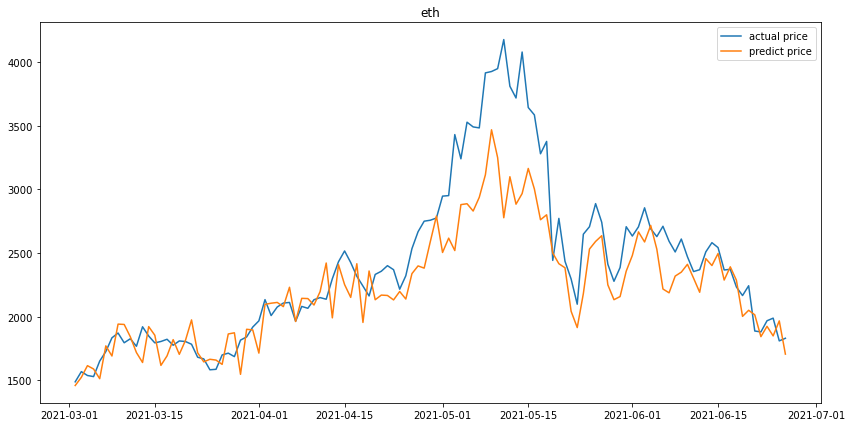

In [178]:
#plot du prix reel et du prix prédit
plot_curves([test_data['close'], predictedprice], ['actual price', 'predict price'], title='eth')

In [180]:
#sauvgarder notre data set et notre scaler
from pickle import dump
from pickle import load
#torch.save(model_btc,"/home/jbouhadoun/esgi/exp/model/model_btc.pth")
#dump(scaler, open('/home/jbouhadoun/esgi/exp/model/btc_scaler.pkl', 'wb'))
